In [1]:
#!pip install pickle5 --quiet

In [2]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
sns.set()

In [3]:
# 제작한 모듈들 임포트
from price.price_processing import *

from backtest.metric import Metric
from strategy.factors.momentum import *
from strategy.optimize.cross_sectional import *
from strategy.optimize.time_series import *

In [4]:
with open('../../part07.-퀀트-트레이딩-실무-실습-파일/chapter3/피클파일/equity_price.pkl', 'rb') as f:
    equity_price = pickle.load(f)
    equity_price.index = pd.to_datetime(equity_price.index)
    equity_price.index.name = 'date_time'
    
equity_price = equity_price.drop(columns='DOW')

In [5]:
#equity_price = equity_price.iloc[:1000, :4]

In [6]:
target_rebal = rebal_dates(price=equity_price, period='month')

In [7]:
rebal_price_df = price_on_rebal(equity_price, target_rebal)

In [49]:
momentum = MomentumFactor(rebal_price_df, 12, 5, long_only=False)
signal = momentum.dual_momentum()

In [50]:
signal

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2011-01-31,1,-1,0,0,1,1,-1,0,0,0,...,-1,0,0,0,0,0,-1,0,0,0
2011-02-28,1,-1,0,0,1,1,-1,1,0,0,...,-1,-1,0,0,0,0,-1,0,0,0
2011-03-31,1,-1,0,0,1,1,-1,1,0,0,...,-1,-1,0,0,0,1,-1,0,0,0
2011-04-29,0,-1,0,0,1,1,-1,1,0,0,...,0,-1,0,0,0,1,-1,1,0,0
2011-05-31,0,0,0,0,1,1,-1,1,0,-1,...,0,-1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0,0,0,-1,0,0,0,1,-1,0,...,1,0,-1,0,1,1,0,0,0,0
2022-07-29,1,0,0,-1,0,0,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0
2022-08-31,0,1,0,0,0,-1,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0
2022-09-30,0,1,0,-1,0,-1,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0


In [51]:
cs_weight = Equalizer(signal=signal, rebal_price=rebal_price_df, param=12)
beta_weight = cs_weight.beta()
ew_weight = cs_weight.ew()
emv_weight = cs_weight.emv()

msr_weight = Optimization(signal=signal, rebal_price=rebal_price_df, param=12, call_method='msr').run()
gmv_weight = Optimization(signal=signal, rebal_price=rebal_price_df, param=12, call_method='gmv').run()
mdp_weight = Optimization(signal=signal, rebal_price=rebal_price_df, param=12, call_method='mdp').run()
rp_weight = Optimization(signal=signal, rebal_price=rebal_price_df, param=12, call_method='rp').run()

cs_model = {'Beta': beta_weight, 
            'EW': ew_weight, 
            'EMV': emv_weight, 
            'MSR': msr_weight, 
            'GMV': gmv_weight, 
            'MDP': mdp_weight, 
            'RP': rp_weight
            }

In [53]:
gmv_weight.sum(axis=1)

2012-01-31    1.0
2012-02-29    1.0
2012-03-30    1.0
2012-04-30    1.0
2012-05-31    1.0
             ... 
2022-06-30    1.0
2022-07-29    1.0
2022-08-31    1.0
2022-09-30    1.0
2022-10-17    1.0
Length: 130, dtype: float64

In [54]:
signal.index#head(5)

DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29',
               '2011-05-31', '2011-06-30', '2011-07-29', '2011-08-31',
               '2011-09-30', '2011-10-31',
               ...
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-30', '2022-10-17'],
              dtype='datetime64[ns]', length=142, freq=None)

In [55]:
def port_rets2(price_df: pd.DataFrame, weight_df: pd.DataFrame, signal_df: pd.DataFrame, cum=True) -> pd.DataFrame:
    """calculate_portvals

    Args:
        price_df (pd.DataFrame): 
        - DataFrame -> 일별 종가를 담고 있는 df
        weight_df (pd.DataFrame): 
        - DataFrame -> 팩터, 최적화가 끝난 최종 투자비중 df

    Returns:
        pd.DataFrame -> 일별 가격의 변동에 따른 최종 투자비중의 일별 변동 => 포트폴리오에 담긴 자산별 가치의 변화를 보여줌 
    """

    individual_port_val_df_list = []
    prev_end_day = weight_df.index[0]
    
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        signal_series = signal_df.loc[prev_end_day]
        sub_rets_df = sub_price_df.pct_change() * signal_series

        weight_series = weight_df.loc[prev_end_day]
        port_rets_series = (sub_rets_df * weight_series)
    
        individual_port_val_df_list.append(port_rets_series)

        prev_end_day = end_day

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df
        

def new_mean(sr):
    array = sr.values
    res = 0
    count = 0
    for num in array:
        if abs(num - 1) < 1e-8:
            continue
        res += num
        count += count
    return res / count if count != 0 else 1

def port_cum_rets2(port_daily_rets):
    return (1 + port_daily_rets.fillna(0)).cumprod().apply(new_mean, axis=1)

In [56]:
equity_price

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date_time,,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.643,57.715,40.92,56.18,58.55,18.7050,24.69,79.06,32.07,173.08,...,35.2900,30.950,16.3375,61.12,49.81,31.53,22.0350,31.0965,37.30,54.23
2010-01-05,7.656,57.220,40.83,58.02,59.25,18.6250,24.58,79.62,31.99,176.14,...,35.4330,30.960,16.4025,61.14,48.63,31.48,21.7825,31.1526,37.00,53.69
2010-01-06,7.535,56.790,41.49,59.78,59.43,18.5925,24.42,79.63,31.82,174.26,...,35.9098,30.770,16.3025,60.85,47.94,31.79,21.4900,29.8257,36.72,53.57
2010-01-07,7.521,56.270,41.98,62.20,59.67,18.5100,24.53,79.33,31.83,177.67,...,35.9670,30.452,16.4625,60.52,48.63,33.01,21.6900,29.6482,36.94,53.60
2010-01-08,7.571,56.770,41.95,61.60,60.34,18.5375,24.66,79.47,31.88,174.31,...,35.9479,30.660,16.4300,60.44,48.56,32.70,21.7500,29.6669,36.99,53.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,138.980,245.440,137.35,131.57,179.75,142.5700,39.58,157.17,93.10,294.21,...,91.0500,225.410,87.9900,124.23,159.46,499.81,179.1400,35.9400,32.61,132.67
2022-10-12,138.340,246.440,136.74,130.42,179.50,142.2900,39.27,157.64,93.41,295.31,...,90.4200,225.750,88.5100,124.43,159.16,499.96,178.2400,35.6800,31.94,131.17
2022-10-13,142.990,251.660,141.55,132.40,183.14,145.4400,40.61,165.28,96.64,307.07,...,92.4900,234.240,89.5600,126.31,165.51,509.91,184.6600,36.4000,33.65,132.28


In [57]:
display(ew_weight)
signal

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2011-01-31,0.1,0.100000,0.0,0.0,0.100000,0.100000,0.100000,0.000000,0.0,0.000,...,0.1,0.000000,0.0,0.0,0.0,0.000000,0.100000,0.000000,0.0,0.0
2011-02-28,0.1,0.100000,0.0,0.0,0.100000,0.100000,0.100000,0.100000,0.0,0.000,...,0.1,0.100000,0.0,0.0,0.0,0.000000,0.100000,0.000000,0.0,0.0
2011-03-31,0.1,0.100000,0.0,0.0,0.100000,0.100000,0.100000,0.100000,0.0,0.000,...,0.1,0.100000,0.0,0.0,0.0,0.100000,0.100000,0.000000,0.0,0.0
2011-04-29,0.0,0.111111,0.0,0.0,0.111111,0.111111,0.111111,0.111111,0.0,0.000,...,0.0,0.111111,0.0,0.0,0.0,0.111111,0.111111,0.111111,0.0,0.0
2011-05-31,0.0,0.000000,0.0,0.0,0.125000,0.125000,0.125000,0.125000,0.0,0.125,...,0.0,0.125000,0.0,0.0,0.0,0.125000,0.000000,0.125000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.0,0.000000,0.0,0.1,0.000000,0.000000,0.000000,0.100000,0.1,0.000,...,0.1,0.000000,0.1,0.0,0.1,0.100000,0.000000,0.000000,0.0,0.0
2022-07-29,0.1,0.000000,0.0,0.1,0.000000,0.000000,0.000000,0.100000,0.1,0.000,...,0.1,0.000000,0.1,0.0,0.0,0.100000,0.000000,0.000000,0.0,0.0
2022-08-31,0.0,0.100000,0.0,0.0,0.000000,0.100000,0.000000,0.100000,0.1,0.000,...,0.1,0.000000,0.1,0.0,0.0,0.100000,0.000000,0.000000,0.0,0.0
2022-09-30,0.0,0.100000,0.0,0.1,0.000000,0.100000,0.000000,0.100000,0.1,0.000,...,0.1,0.000000,0.1,0.0,0.0,0.100000,0.000000,0.000000,0.0,0.0


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2011-01-31,1,-1,0,0,1,1,-1,0,0,0,...,-1,0,0,0,0,0,-1,0,0,0
2011-02-28,1,-1,0,0,1,1,-1,1,0,0,...,-1,-1,0,0,0,0,-1,0,0,0
2011-03-31,1,-1,0,0,1,1,-1,1,0,0,...,-1,-1,0,0,0,1,-1,0,0,0
2011-04-29,0,-1,0,0,1,1,-1,1,0,0,...,0,-1,0,0,0,1,-1,1,0,0
2011-05-31,0,0,0,0,1,1,-1,1,0,-1,...,0,-1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0,0,0,-1,0,0,0,1,-1,0,...,1,0,-1,0,1,1,0,0,0,0
2022-07-29,1,0,0,-1,0,0,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0
2022-08-31,0,1,0,0,0,-1,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0
2022-09-30,0,1,0,-1,0,-1,0,1,-1,0,...,1,0,-1,0,0,1,0,0,0,0


In [64]:
def calculate_portvals(price_df: pd.DataFrame, weight_df: pd.DataFrame, signal_df: pd.DataFrame) -> pd.DataFrame:
    cum_rtn_up_until_now = 1 
    individual_port_val_df_list = []
    prev_end_day = weight_df.index[0]
    
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        signal_series = signal_df.loc[prev_end_day]
        display(signal_series)
        long_signal = signal_series.replace({-1: 0})
        short_signal = signal_series.replace({1: 0, -1: 1})
        display(long_signal)
        display(short_signal)
        sub_price_df_reverse = sub_price_df.sort_index(ascending=False)
        
        sub_asset_flow_df = sub_price_df/sub_price_df.iloc[0]
        sub_asset_flow_df_reverse = sub_price_df_reverse/sub_price_df_reverse.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        long_weight_series = weight_series * long_signal
        short_weight_series = weight_series * short_signal
        
        indi_port_cum_rtn_series = (sub_asset_flow_df * long_weight_series) * cum_rtn_up_until_now\
            + (sub_asset_flow_df_reverse * short_weight_series) * cum_rtn_up_until_now
    
        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day 

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

def get_daily_rets(individual_port_val_df: pd.DataFrame, signal_df: pd.DataFrame, N: int=1, log: bool=False) -> pd.DataFrame:
    """get_daily_rets

    Args:
        individual_port_val_df (pd.DataFrame): 
            - DataFrame -> culate_portvals의 리턴 값으로 일별 투자비중의 변동을 나타내는 df
        N (int): 
            - int: 수익률을 구하기 위한 look-back window -> default=1
        log (bool): 
            - bool: 로그 수익률을 사용할지 결정 -> default=False

    Returns:
        pd.DataFrame -> 포트폴리오의 일별 수익룰 df
    """

    portval_df = (individual_port_val_df * signal_df).sum(axis=1)
    
    if log:
        return np.log(portval_df/portval_df.shift(N)).iloc[N-1:].fillna(0)
    
    else:
        return portval_df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

In [65]:
port_val_df = calculate_portvals(equity_price, ew_weight, signal)
display(port_val_df)

AAPL    1
AMGN   -1
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     0
DIS     0
GS      0
HD      0
HON     1
IBM     1
INTC    0
JNJ    -1
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V      -1
VZ      0
WBA     0
WMT     0
Name: 2011-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     1
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-01-31 00:00:00, dtype: int64

AAPL    1
AMGN   -1
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     1
DIS     0
GS      0
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT   -1
NKE     0
PG      0
TRV     0
UNH     0
V      -1
VZ      0
WBA     0
WMT     0
Name: 2011-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-02-28 00:00:00, dtype: int64

AAPL    1
AMGN   -1
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT   -1
NKE     0
PG      0
TRV     0
UNH     1
V      -1
VZ      0
WBA     0
WMT     0
Name: 2011-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-03-31 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT   -1
NKE     0
PG      0
TRV     0
UNH     1
V      -1
VZ      1
WBA     0
WMT     0
Name: 2011-04-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      1
WBA     0
WMT     0
Name: 2011-04-29 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-04-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     1
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT   -1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      1
WBA     0
WMT     0
Name: 2011-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      1
WBA     0
WMT     0
Name: 2011-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     0
DIS     0
GS      0
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2011-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2011-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO   -1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-07-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-07-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-07-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO   -1
CVX     1
DIS     0
GS     -1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO   -1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM    -1
KO      1
MCD     1
MMM    -1
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO   -1
CVX     1
DIS     0
GS     -1
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM    -1
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2011-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM    -1
CSCO    0
CVX     1
DIS     0
GS     -1
HD      1
HON     0
IBM     1
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA    -1
WMT     0
Name: 2011-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      1
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2011-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM    -1
CSCO   -1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA    -1
WMT     0
Name: 2011-12-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT     0
Name: 2011-12-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2011-12-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM    -1
CSCO   -1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA    -1
WMT     0
Name: 2012-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS    -1
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     1
MMM    -1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA    -1
WMT     0
Name: 2012-02-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-02-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-02-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ     -1
WBA    -1
WMT     0
Name: 2012-03-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-03-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2012-03-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2012-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     1
Name: 2012-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     1
Name: 2012-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM    -1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     1
Name: 2012-06-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     1
Name: 2012-06-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-06-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM    -1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     1
Name: 2012-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     1
Name: 2012-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2012-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     1
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM    -1
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2012-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-09-28 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-09-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2012-09-28 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO   -1
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2012-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2012-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2012-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2012-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA     -1
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT   -1
NKE     0
PG      0
TRV     1
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-01-31 00:00:00, dtype: int64

AAPL   -1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT   -1
NKE     0
PG      0
TRV     1
UNH    -1
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-02-28 00:00:00, dtype: int64

AAPL   -1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT   -1
NKE     0
PG      0
TRV     1
UNH    -1
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-03-28 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-03-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-03-28 00:00:00, dtype: int64

AAPL   -1
AMGN    1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-04-30 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-05-31 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-06-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-06-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-06-28 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      1
HON     1
IBM    -1
INTC   -1
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      1
HON     1
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-07-31 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     0
BA      1
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     1
IBM    -1
INTC   -1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-08-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2013-08-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-08-30 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     0
BA      1
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2013-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-09-30 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     1
BA      1
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-10-31 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP     1
BA      1
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-11-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-11-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-11-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2013-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2013-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     1
BA      1
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     1
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD    -1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     1
WMT     0
Name: 2014-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2014-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD    -1
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     1
WMT     0
Name: 2014-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2014-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-05-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-05-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-05-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     1
WMT     0
Name: 2014-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2014-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO     -1
MCD    -1
MMM     0
MRK     0
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT    -1
Name: 2014-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2014-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-08-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-08-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-08-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     0
WMT    -1
Name: 2014-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     1
Name: 2014-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-11-28 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-11-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2014-11-28 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     1
WMT     0
Name: 2014-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2014-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2014-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM    -1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2015-01-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2015-01-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     1
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-01-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    1
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-02-27 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-02-27 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-02-27 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     1
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT   -1
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-05-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-05-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-05-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     1
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG     -1
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX    -1
DIS     1
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT    -1
Name: 2015-10-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     1
WMT     0
Name: 2015-10-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2015-10-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT    -1
Name: 2015-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2015-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2015-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT    -1
Name: 2015-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2015-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2015-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA     -1
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT    -1
Name: 2016-01-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-01-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-01-29 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA     -1
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-02-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-02-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-02-29 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT    -1
Name: 2016-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-03-31 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT    -1
Name: 2016-04-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-04-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-04-29 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA     -1
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2016-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-05-31 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS    -1
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2016-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2016-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-06-30 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS    -1
GS     -1
HD      1
HON     0
IBM     0
INTC    1
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA    -1
WMT     0
Name: 2016-07-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2016-07-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2016-07-29 00:00:00, dtype: int64

AAPL   -1
AMGN    0
AXP    -1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS    -1
GS     -1
HD      0
HON     0
IBM     0
INTC    1
JNJ     1
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2016-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     1
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2016-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP    -1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS    -1
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2016-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2016-09-30 00:00:00, dtype: int64

AAPL   -1
AMGN   -1
AXP    -1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-10-31 00:00:00, dtype: int64

AAPL   -1
AMGN   -1
AXP     0
BA      0
CAT     1
CRM    -1
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2016-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-11-30 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     0
BA      0
CAT     1
CRM    -1
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA    -1
WMT     0
Name: 2016-12-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2016-12-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2016-12-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD    -1
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA    -1
WMT     0
Name: 2017-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2017-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    1
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-04-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-04-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-04-28 00:00:00, dtype: int64

AAPL    1
AMGN   -1
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA    -1
WMT     0
Name: 2017-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2017-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     0
WMT     0
Name: 2017-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2017-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA    -1
WMT     0
Name: 2017-09-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-09-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2017-09-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK    -1
MSFT    0
NKE     0
PG     -1
TRV     0
UNH     1
V       0
VZ     -1
WBA    -1
WMT     0
Name: 2017-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2017-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2017-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2017-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2017-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2017-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ     -1
WBA    -1
WMT     0
Name: 2017-12-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2017-12-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     1
WMT     0
Name: 2017-12-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS    -1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     1
Name: 2018-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     1
Name: 2018-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS    -1
GS      0
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2018-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS    -1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2018-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS    -1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG     -1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2018-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS    -1
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2018-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC    1
JNJ    -1
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2018-06-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-06-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-06-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ    -1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG     -1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2018-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2018-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG     -1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2018-09-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-09-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2018-09-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT    -1
CRM     1
CSCO    1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE     1
PG      0
TRV    -1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    1
NKE     0
PG      0
TRV    -1
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2018-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2018-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE     1
PG      0
TRV    -1
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE     1
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     1
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    0
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM    -1
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-03-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     1
CSCO    0
CVX    -1
DIS     1
GS     -1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2019-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     1
GS     -1
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     1
MMM    -1
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2019-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     1
GS     -1
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     1
MMM    -1
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2019-06-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2019-06-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-06-28 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    1
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2019-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM    -1
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH    -1
V       1
VZ      0
WBA    -1
WMT     0
Name: 2019-08-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     1
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-08-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-08-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM    -1
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH    -1
V       0
VZ      0
WBA    -1
WMT     1
Name: 2019-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     1
MMM     0
MRK     1
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2019-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS     -1
HD      1
HON     0
IBM     0
INTC    1
JNJ    -1
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2019-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-10-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-10-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO   -1
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ    -1
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2019-11-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-11-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     1
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-11-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2019-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2019-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2019-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO   -1
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2020-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2020-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO   -1
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA    -1
WMT     0
Name: 2020-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      0
WBA     0
WMT     0
Name: 2020-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      1
TRV    -1
UNH     0
V       0
VZ      0
WBA    -1
WMT     1
Name: 2020-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      1
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2020-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA     -1
CAT     0
CRM     0
CSCO   -1
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV    -1
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2020-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     1
Name: 2020-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA     -1
CAT     0
CRM     0
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV    -1
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-05-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-05-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-05-29 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA     -1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV    -1
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP    -1
BA     -1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV    -1
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-07-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-07-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA     -1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV    -1
UNH     1
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-08-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     1
CSCO   -1
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV    -1
UNH     1
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-09-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP    -1
BA     -1
CAT     0
CRM     1
CSCO   -1
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-10-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-10-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     0
CRM     0
CSCO    1
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-10-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM    -1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     1
Name: 2020-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     1
Name: 2020-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     1
CSCO    0
CVX    -1
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA    -1
WMT     0
Name: 2020-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2020-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2020-12-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     1
CRM     1
CSCO    0
CVX    -1
DIS     0
GS      0
HD      0
HON     0
IBM    -1
INTC   -1
JNJ     0
JPM     0
KO     -1
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-01-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-01-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    1
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-01-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM    -1
INTC    0
JNJ     0
JPM     0
KO     -1
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-02-26 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-02-26 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     1
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-02-26 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-04-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-04-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2021-05-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      1
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-05-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2021-05-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-06-30 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2021-07-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-07-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2021-07-30 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     1
BA      0
CAT     1
CRM    -1
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2021-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2021-08-31 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK    -1
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ     -1
WBA     0
WMT    -1
Name: 2021-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     1
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     1
Name: 2021-09-30 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ     -1
WBA     0
WMT     0
Name: 2021-10-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      1
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-10-29 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2021-10-29 00:00:00, dtype: int64

AAPL    1
AMGN   -1
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V      -1
VZ     -1
WBA     0
WMT    -1
Name: 2021-11-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     1
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-11-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       1
VZ      1
WBA     0
WMT     1
Name: 2021-11-30 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    1
CVX     0
DIS    -1
GS      1
HD      1
HON    -1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     0
WMT     0
Name: 2021-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    1
CVX     0
DIS     0
GS      1
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2021-12-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     1
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2021-12-31 00:00:00, dtype: int64

AAPL    0
AMGN   -1
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      1
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ     -1
WBA     0
WMT     0
Name: 2022-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      1
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-01-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      1
WBA     0
WMT     0
Name: 2022-01-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT    -1
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON    -1
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-02-28 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     1
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     1
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-02-28 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA    -1
WMT     0
Name: 2022-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     1
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    1
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-03-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     1
WMT     0
Name: 2022-03-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM    -1
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      0
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-04-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      1
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-04-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-04-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM    -1
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      1
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-05-31 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-05-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      1
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE    -1
PG      0
TRV     1
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     1
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-06-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-06-30 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA     -1
CAT     0
CRM     0
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      1
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-07-29 00:00:00, dtype: int64

AAPL    1
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-07-29 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-07-29 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM    -1
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      1
MCD     0
MMM    -1
MRK     1
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     1
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-08-31 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA     -1
CAT     0
CRM    -1
CSCO    0
CVX     1
DIS    -1
GS      0
HD      0
HON     0
IBM     0
INTC   -1
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE    -1
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    1
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     1
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      1
MCD     0
MMM     0
MRK     1
MSFT    0
NKE     0
PG      0
TRV     0
UNH     1
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-09-30 00:00:00, dtype: int64

AAPL    0
AMGN    0
AXP     0
BA      1
CAT     0
CRM     1
CSCO    0
CVX     0
DIS     1
GS      0
HD      0
HON     0
IBM     0
INTC    1
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     1
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
Name: 2022-09-30 00:00:00, dtype: int64

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.100000,0.107306,0.0,0.000000,0.100000,0.100000,0.113955,0.000000,0.000000,0.0,...,0.101842,0.0,0.000000,0.0,0.0,0.000000,0.095619,0.0,0.0,0.0
2011-02-01,0.101683,0.108533,0.0,0.000000,0.101031,0.101936,0.115679,0.000000,0.000000,0.0,...,0.104391,0.0,0.000000,0.0,0.0,0.000000,0.096783,0.0,0.0,0.0
2011-02-02,0.101469,0.108377,0.0,0.000000,0.102144,0.104600,0.116487,0.000000,0.000000,0.0,...,0.103838,0.0,0.000000,0.0,0.0,0.000000,0.098686,0.0,0.0,0.0
2011-02-03,0.101213,0.108026,0.0,0.000000,0.101979,0.103895,0.118050,0.000000,0.000000,0.0,...,0.101013,0.0,0.000000,0.0,0.0,0.000000,0.098056,0.0,0.0,0.0
2011-02-04,0.102112,0.107539,0.0,0.000000,0.102660,0.106822,0.118804,0.000000,0.000000,0.0,...,0.100983,0.0,0.000000,0.0,0.0,0.000000,0.099795,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,0.000000,0.174107,0.0,0.154581,0.000000,0.154883,0.000000,0.174915,0.152942,0.0,...,0.169044,0.0,0.156372,0.0,0.0,0.158235,0.000000,0.0,0.0,0.0
2022-10-12,0.000000,0.174816,0.0,0.153229,0.000000,0.154579,0.000000,0.175438,0.153451,0.0,...,0.167875,0.0,0.157296,0.0,0.0,0.158283,0.000000,0.0,0.0,0.0
2022-10-13,0.000000,0.178519,0.0,0.155556,0.000000,0.158001,0.000000,0.183941,0.158758,0.0,...,0.171718,0.0,0.159162,0.0,0.0,0.161433,0.000000,0.0,0.0,0.0


In [ ]:
daily_rets = port_daily_rets2(price_df=equity_price, weight_df=ew_weight, signal_df=signal)
daily_rets

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,0.003367,0.000000,0.0,0.0,0.002062,0.003872,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2011-02-02,-0.000422,-0.000000,0.0,0.0,0.002204,0.005226,0.0,0.000000,0.0,-0.0,...,-0.000000,-0.0,0.0,-0.0,-0.0,-0.000000,0.0,-0.0,-0.0,-0.0
2011-02-03,-0.000504,-0.000000,-0.0,-0.0,-0.000323,-0.001347,0.0,0.000000,0.0,-0.0,...,-0.000000,-0.0,-0.0,0.0,0.0,0.000000,-0.0,0.0,0.0,0.0
2011-02-04,0.001777,-0.000000,0.0,0.0,0.001334,0.005635,0.0,-0.000000,0.0,0.0,...,-0.000000,0.0,0.0,0.0,0.0,-0.000000,0.0,-0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,-0.000000,0.011449,-0.0,-0.0,0.000000,-0.000000,-0.0,0.000038,-0.0,-0.0,...,0.001260,-0.0,0.0,0.0,0.0,0.000381,-0.0,-0.0,0.0,0.0
2022-10-12,-0.000000,0.000815,-0.0,-0.0,-0.000000,-0.000000,-0.0,0.000598,0.0,0.0,...,-0.001384,0.0,0.0,0.0,-0.0,0.000060,-0.0,-0.0,-0.0,-0.0
2022-10-13,0.000000,0.004236,0.0,0.0,0.000000,0.000000,0.0,0.009693,0.0,0.0,...,0.004579,0.0,0.0,0.0,0.0,0.003980,0.0,0.0,0.0,0.0


In [41]:
(1 + daily_rets.fillna(0)).cumprod()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-01,1.003367,1.000000,1.000000,1.000000,1.002062,1.003872,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-02,1.002943,1.000000,1.000000,1.000000,1.004270,1.009118,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-03,1.002438,1.000000,1.000000,1.000000,1.003946,1.007759,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-04,1.004219,1.000000,1.000000,1.000000,1.005285,1.013437,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,1.314671,1.132498,1.048648,1.142617,0.993776,1.060377,0.925985,1.080043,0.998282,1.054276,...,1.022441,1.161811,0.994765,1.029558,1.011934,1.158003,1.212711,0.984648,1.021577,0.990161
2022-10-12,1.314671,1.133420,1.048648,1.142617,0.993776,1.060377,0.925985,1.080689,0.998282,1.054276,...,1.021026,1.161811,0.994765,1.029558,1.011934,1.158073,1.212711,0.984648,1.021577,0.990161
2022-10-13,1.314671,1.138222,1.048648,1.142617,0.993776,1.060377,0.925985,1.091164,0.998282,1.054276,...,1.025701,1.161811,0.994765,1.029558,1.011934,1.162682,1.212711,0.984648,1.021577,0.990161


In [39]:
port_cum_rets2(daily_rets)

date_time
2011-01-31    1
2011-02-01    1
2011-02-02    1
2011-02-03    1
2011-02-04    1
             ..
2022-10-11    1
2022-10-12    1
2022-10-13    1
2022-10-14    1
2022-10-17    1
Length: 2949, dtype: int64

Beta


TypeError: 'Text' object is not callable

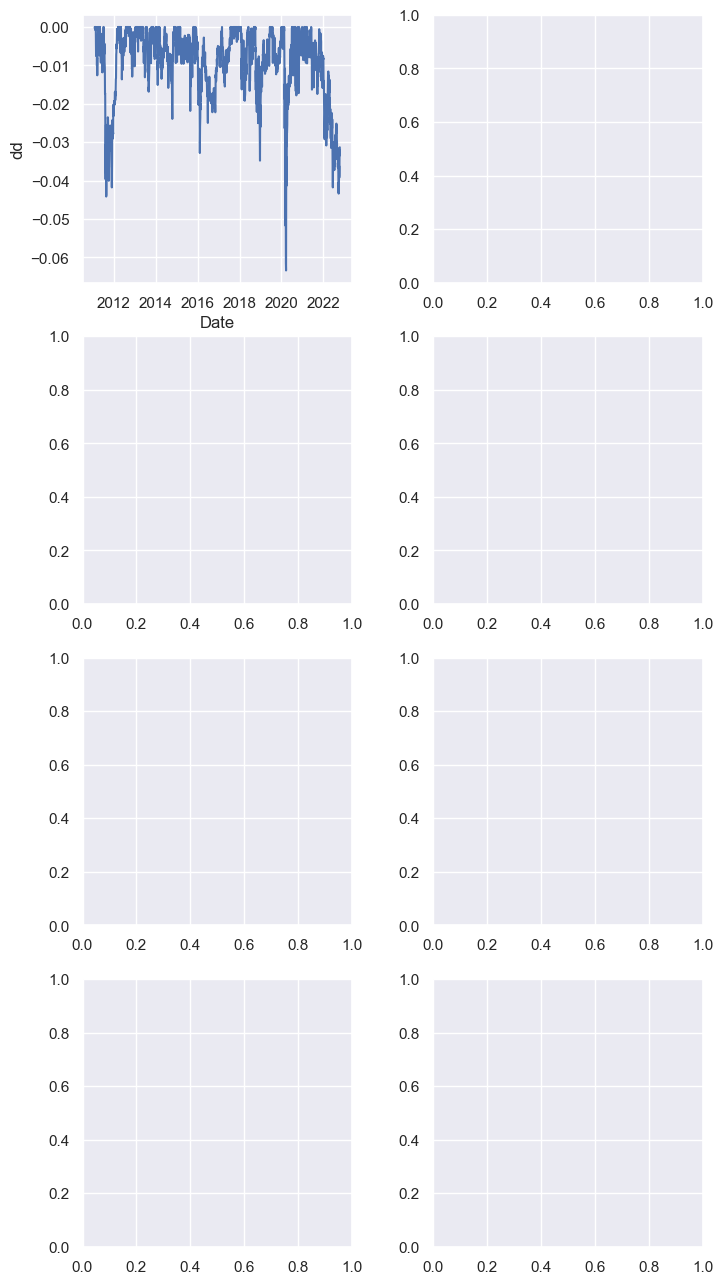

In [32]:
for name, weight in cs_model.items():
    print(name)
    cum_rets = port_cum_rets(port_daily_rets(price_df=equity_price, weight_df=weight, signal_df=signal))
    #display(Metric(cum_rets).rolling_metric()['dd'].plot())
    #plt.show()
    Metric(portfolio=cum_rets).plot_report()
    print()